In [1]:
from numpy import *
import matplotlib.pyplot as plt

In [3]:
#建立一个类存放基本数据以及alphas的缓存
class optStruct:
    def __init__(self, dataMatIn, classLabels, C, toler):  # Initialize the structure with the parameters
        self.X = dataMatIn
        self.labelMat = classLabels
        self.C = C
        self.tol = toler
        self.m = shape(dataMatIn)[0]
        self.alphas = mat(zeros((self.m, 1)))
        self.b = 0
        self.eCache = mat(zeros((self.m, 2)))  # 第一列是有效标志位，第二列是E值

In [5]:
def loadDataSet(fileName):
    """loadDataSet（对文件进行逐行解析，从而得到每行的类标签和整个数据矩阵）

    Args:
        fileName 文件名
    Returns:
        dataMat  数据矩阵
        labelMat 类标签
    """
    dataMat = []
    labelMat = []
    fr = open(fileName)
    for line in fr.readlines():
        lineArr = line.strip().split('\t')
        dataMat.append([float(lineArr[0]), float(lineArr[1])])
        labelMat.append(float(lineArr[2]))
    return dataMat, labelMat

In [10]:
#the same as simple smo
def selectJrand(i, m):
    """
    随机选择一个整数
    Args:
        i  第一个alpha的下标
        m  所有alpha的数目
    Returns:
        j  返回一个不为i的随机数，在0~m之间的整数值
    """
    j = i
    while j == i:
        j = int(random.uniform(0, m))
    return j

In [11]:
#the same as simple smo
def clipAlpha(aj, H, L):
    """clipAlpha(调整aj的值，使aj处于 L<=aj<=H)
    Args:
        aj  目标值
        H   最大值
        L   最小值
    Returns:
        aj  目标值
    """
    if aj > H:
        aj = H
    if L > aj:
        aj = L
    return aj

In [23]:
#EK计算较多，所以单独拎出来
def calcEk(oS, k):
    """calcEk（求 Ek误差：预测值-真实值的差）

    该过程在完整版的SMO算法中陪出现次数较多，因此将其单独作为一个方法
    Args:
        oS  optStruct对象
        k   具体的某一行

    Returns:
        Ek  预测结果与真实结果比对，计算误差Ek
    """
    fXk = float(multiply(oS.alphas, oS.labelMat).T * (oS.X * oS.X[k, :].T)) + oS.b
    Ek = fXk - float(oS.labelMat[k])
    return Ek

In [16]:
#platt-smo重点
#在选择第2个alphas参数时（也就是进行SMO的内循环时），不再是随机选择，而是选择最长步长的那个（就是选择|E_i-Ej|最大的）
def selectJ(i, oS, Ei):  # this is the second choice -heurstic, and calcs Ej
    """selectJ（返回最优的j和Ej）

    内循环的启发式方法。
    选择第二个(内循环)alpha的alpha值
    这里的目标是选择合适的第二个alpha值以保证每次优化中采用最大步长。
    该函数的误差与第一个alpha值Ei和下标i有关。
    Args:
        i   具体的第i一行
        oS  optStruct对象
        Ei  预测结果与真实结果比对，计算误差Ei

    Returns:
        j  随机选出的第j一行
        Ej 预测结果与真实结果比对
        ，计算误差Ej
    """
    maxK = -1
    maxDeltaE = 0
    Ej = 0
    # 首先将输入值Ei在缓存中设置成为有效的。这里的有效意味着它已经计算好了。
    oS.eCache[i] = [1, Ei]

    # print 'oS.eCache[%s]=%s' % (i, oS.eCache[i])
    # print 'oS.eCache[:, 0].A=%s' % oS.eCache[:, 0].A.T
    # """
    # # 返回非0的：行列值
    # nonzero(oS.eCache[:, 0].A)= (
    #     行： array([ 0,  2,  4,  5,  8, 10, 17, 18, 20, 21, 23, 25, 26, 29, 30, 39, 46,52, 54, 55, 62, 69, 70, 76, 79, 82, 94, 97]), 
    #     列： array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,0, 0, 0, 0, 0])
    # )
    # """
    # print 'nonzero(oS.eCache[:, 0].A)=', nonzero(oS.eCache[:, 0].A)
    # # 取行的list
    # print 'nonzero(oS.eCache[:, 0].A)[0]=', nonzero(oS.eCache[:, 0].A)[0]
    
    # 非零E值的行的list列表，所对应的alpha值
    validEcacheList = nonzero(oS.eCache[:, 0].A)[0]
    if (len(validEcacheList)) > 1:
        for k in validEcacheList:  # 在所有的值上进行循环，并选择其中使得改变最大的那个值
            if k == i:
                continue  # don't calc for i, waste of time如果j=i直接跳过

            # 求 Ek误差：预测值-真实值的差
            Ek = calcEk(oS, k)
            deltaE = abs(Ei - Ek)
            if (deltaE > maxDeltaE):
                maxK = k#get max j下标
                maxDeltaE = deltaE#get max j's deltaE
                Ej = Ek
        return maxK, Ej
    else:  # 如果是第一次循环，则随机选择一个alpha值
        j = selectJrand(i, oS.m)

        # 求 Ek误差：预测值-真实值的差
        Ej = calcEk(oS, j)
    return j, Ej

In [18]:
#更新错误率Ek
def updateEk(oS, k):  # after any alpha has changed update the new value in the cache
    """updateEk（计算误差值并存入缓存中。）

    在对alpha值进行优化之后会用到这个值。
    Args:
        oS  optStruct对象
        k   某一列的行号
    """

    # 求 误差：预测值-真实值的差
    Ek = calcEk(oS, k)
    oS.eCache[k] = [1, Ek]

In [24]:
#更新b并且返回两个alpha参数是否改变的情况，内循环
def innerL(i, oS):
    """innerL
    内循环代码
    Args:
        i   具体的某一行
        oS  optStruct对象

    Returns:
        0   找不到最优的值
        1   找到了最优的值，并且oS.Cache到缓存中
    """

    # 求 Ek误差：预测值-真实值的差
    Ei = calcEk(oS, i)

    # 约束条件 (KKT条件是解决最优化问题的时用到的一种方法。我们这里提到的最优化问题通常是指对于给定的某一函数，求其在指定作用域上的全局最小值)
    # 0<=alphas[i]<=C，但由于0和C是边界值，我们无法进行优化，因为需要增加一个alphas和降低一个alphas。
    # 表示发生错误的概率：labelMat[i]*Ei 如果超出了 toler， 才需要优化。至于正负号，我们考虑绝对值就对了。
    '''
    # 检验训练样本(xi, yi)是否满足KKT条件
    yi*f(i) >= 1 and alpha = 0 (outside the boundary)
    yi*f(i) == 1 and 0<alpha< C (on the boundary)
    yi*f(i) <= 1 and alpha = C (between the boundary)
    '''
    if ((oS.labelMat[i] * Ei < -oS.tol) and (oS.alphas[i] < oS.C)) or ((oS.labelMat[i] * Ei > oS.tol) and (oS.alphas[i] > 0)):
        # 选择最大的误差对应的j进行优化。效果更明显
        j, Ej = selectJ(i, oS, Ei)#这里在选择j处进行了优化
        alphaIold = oS.alphas[i].copy()
        alphaJold = oS.alphas[j].copy()

        # L和H用于将alphas[j]调整到0-C之间。如果L==H，就不做任何改变，直接return 0
        if (oS.labelMat[i] != oS.labelMat[j]):
            L = max(0, oS.alphas[j] - oS.alphas[i])
            H = min(oS.C, oS.C + oS.alphas[j] - oS.alphas[i])
        else:
            L = max(0, oS.alphas[j] + oS.alphas[i] - oS.C)
            H = min(oS.C, oS.alphas[j] + oS.alphas[i])
        if L == H:
            print("L==H")
            return 0

        # eta是alphas[j]的最优修改量，如果eta==0，需要退出for循环的当前迭代过程
        # 参考《统计学习方法》李航-P125~P128<序列最小最优化算法>
        eta = 2.0 * oS.X[i, :] * oS.X[j, :].T - oS.X[i, :] * oS.X[i, :].T - oS.X[j, :] * oS.X[j, :].T
        if eta >= 0:
            print("eta>=0")
            return 0

        # 计算出一个新的alphas[j]值
        oS.alphas[j] -= oS.labelMat[j] * (Ei - Ej) / eta
        # 并使用辅助函数，以及L和H对其进行调整
        oS.alphas[j] = clipAlpha(oS.alphas[j], H, L)
        # 更新误差缓存
        updateEk(oS, j)

        # 检查alpha[j]是否只是轻微的改变，如果是的话，就退出for循环。
        if (abs(oS.alphas[j] - alphaJold) < 0.00001):
            print("j not moving enough")
            return 0

        # 然后alphas[i]和alphas[j]同样进行改变，虽然改变的大小一样，但是改变的方向正好相反
        oS.alphas[i] += oS.labelMat[j] * oS.labelMat[i] * (alphaJold - oS.alphas[j])
        # 更新误差缓存
        updateEk(oS, i)

        # 在对alpha[i], alpha[j] 进行优化之后，给这两个alpha值设置一个常数b。
        # w= Σ[1~n] ai*yi*xi => b = yj Σ[1~n] ai*yi(xi*xj)
        # 所以：  b1 - b = (y1-y) - Σ[1~n] yi*(a1-a)*(xi*x1)
        # 为什么减2遍？ 因为是 减去Σ[1~n]，正好2个变量i和j，所以减2遍
        b1 = oS.b - Ei - oS.labelMat[i] * (oS.alphas[i] - alphaIold) * oS.X[i, :] * oS.X[i, :].T - oS.labelMat[j] * (oS.alphas[j] - alphaJold) * oS.X[i, :] * oS.X[j, :].T
        b2 = oS.b - Ej - oS.labelMat[i] * (oS.alphas[i] - alphaIold) * oS.X[i, :] * oS.X[j, :].T - oS.labelMat[j] * (oS.alphas[j] - alphaJold) * oS.X[j, :] * oS.X[j, :].T
        if (0 < oS.alphas[i]) and (oS.C > oS.alphas[i]):
            oS.b = b1
        elif (0 < oS.alphas[j]) and (oS.C > oS.alphas[j]):
            oS.b = b2
        else:
            oS.b = (b1 + b2) / 2.0
        return 1
    else:
        return 0

In [28]:
#完整版SMO算法
def smoP(dataMatIn, classLabels, C, toler, maxIter):
    """
    完整SMO算法外循环，与smoSimple有些类似，但这里的循环退出条件更多一些
    Args:
        dataMatIn    数据集
        classLabels  类别标签
        C   松弛变量(常量值)，允许有些数据点可以处于分隔面的错误一侧。
            控制最大化间隔和保证大部分的函数间隔小于1.0这两个目标的权重。
            可以通过调节该参数达到不同的结果。
        toler   容错率
        maxIter 退出前最大的循环次数
    Returns:
        b       模型的常量值
        alphas  拉格朗日乘子
    """

    # 创建一个 optStruct 对象
    oS = optStruct(mat(dataMatIn), mat(classLabels).transpose(), C, toler)
    iter = 0 # 迭代次数的初始化
    entireSet = True # 违反 KKT 条件的标志符
    alphaPairsChanged = 0 # 迭代中优化的次数

    # 循环遍历：循环maxIter次 并且 （alphaPairsChanged存在可以改变 or 所有行遍历一遍）
    # 循环迭代结束 或者 循环遍历所有alpha后，alphaPairs还是没变化
    '''
    外层循环首先遍历所有满足0到C范围内的alpha，即在间隔边界上的支持向量点，
    检验它们是否满足KKT条件。如果这些样本点都满足KKT条件，那么遍历整个训练集，检验它们是否满足KKT条件。
    '''
    # 优化的终止条件：在规定迭代次数下，是否遍历了整个样本或 alpha 是否优化
    while (iter < maxIter) and ((alphaPairsChanged > 0) or (entireSet)):
        alphaPairsChanged = 0

        #  当entireSet=true or 非边界alpha对没有了；就开始寻找 alpha对，然后决定是否要进行else。
        if entireSet:
            # 在数据集上遍历所有的alpha
            for i in range(oS.m):
                # 是否存在alpha对，存在就+1
                alphaPairsChanged += innerL(i, oS)
                print("fullSet, iter: %d i:%d, pairs changed %d" % (iter, i, alphaPairsChanged))
            iter += 1
        # 对已存在 alpha对，选出非边界的alpha值，进行优化。
        else:
            # 遍历所有的非边界alpha值，也就是不在边界0或C上的值。
            nonBoundIs = nonzero((oS.alphas.A > 0) * (oS.alphas.A < C))[0] # 遍历所有非边界样本集
            for i in nonBoundIs:
                alphaPairsChanged += innerL(i, oS)
                print("non-bound, iter: %d i:%d, pairs changed %d" % (iter, i, alphaPairsChanged))
            iter += 1

        # 如果找到alpha对，就优化非边界alpha值，否则，就重新进行寻找，如果寻找一遍 遍历所有的行还是没找到，就退出循环。
        if entireSet:
            entireSet = False  # toggle entire set loop
        elif (alphaPairsChanged == 0):
            entireSet = True
        print("iteration number: %d" % iter)
    return oS.b, oS.alphas

In [30]:
#the same as simple smo
def calcWs(alphas, dataArr, classLabels):
    """
    基于alpha计算w值
    Args:
        alphas        拉格朗日乘子
        dataArr       feature数据集
        classLabels   目标变量数据集

    Returns:
        wc  回归系数
    """
    X = mat(dataArr)
    labelMat = mat(classLabels).transpose()
    m, n = shape(X)
    w = zeros((n, 1))
    for i in range(m):
        w += multiply(alphas[i] * labelMat[i], X[i, :].T)
    return w

In [32]:
def plotfig_SVM(xArr, yArr, ws, b, alphas):
    """
    参考地址：
       http://blog.csdn.net/maoersong/article/details/24315633
       http://www.cnblogs.com/JustForCS/p/5283489.html
       http://blog.csdn.net/kkxgx/article/details/6951959
    """

    xMat = mat(xArr)
    yMat = mat(yArr)

    # b原来是矩阵，先转为数组类型后其数组大小为（1,1），所以后面加[0]，变为(1,)
    b = array(b)[0]
    fig = plt.figure()
    ax = fig.add_subplot(111)

    # 注意flatten的用法
    ax.scatter(xMat[:, 0].flatten().A[0], xMat[:, 1].flatten().A[0])

    # x最大值，最小值根据原数据集dataArr[:, 0]的大小而定
    x = arange(-1.0, 10.0, 0.1)

    # 根据x.w + b = 0 得到，其式子展开为w0.x1 + w1.x2 + b = 0, x2就是y值
    y = (-b-ws[0, 0]*x)/ws[1, 0]
    ax.plot(x, y)

    for i in range(shape(yMat[0, :])[1]):
        if yMat[0, i] > 0:
            ax.plot(xMat[i, 0], xMat[i, 1], 'cx')
        else:
            ax.plot(xMat[i, 0], xMat[i, 1], 'kp')

    # 找到支持向量，并在图中标红
    for i in range(100):
        if alphas[i] > 0.0:
            ax.plot(xMat[i, 0], xMat[i, 1], 'ro')
    plt.show()

L==H
fullSet, iter: 0 i:0, pairs changed 0
L==H
fullSet, iter: 0 i:1, pairs changed 0
fullSet, iter: 0 i:2, pairs changed 1
L==H
fullSet, iter: 0 i:3, pairs changed 1
fullSet, iter: 0 i:4, pairs changed 2
fullSet, iter: 0 i:5, pairs changed 2
fullSet, iter: 0 i:6, pairs changed 2
j not moving enough
fullSet, iter: 0 i:7, pairs changed 2
L==H
fullSet, iter: 0 i:8, pairs changed 2
fullSet, iter: 0 i:9, pairs changed 2
L==H
fullSet, iter: 0 i:10, pairs changed 2
L==H
fullSet, iter: 0 i:11, pairs changed 2
L==H
fullSet, iter: 0 i:12, pairs changed 2
fullSet, iter: 0 i:13, pairs changed 2
L==H
fullSet, iter: 0 i:14, pairs changed 2
fullSet, iter: 0 i:15, pairs changed 2
fullSet, iter: 0 i:16, pairs changed 2
L==H
fullSet, iter: 0 i:17, pairs changed 2
fullSet, iter: 0 i:18, pairs changed 3
fullSet, iter: 0 i:19, pairs changed 3
fullSet, iter: 0 i:20, pairs changed 3
fullSet, iter: 0 i:21, pairs changed 3
j not moving enough
fullSet, iter: 0 i:22, pairs changed 3
L==H
fullSet, iter: 0 i:23, 

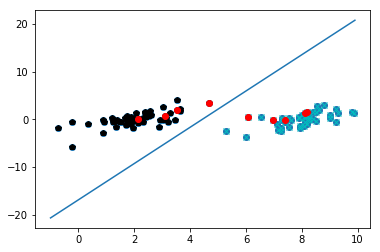

In [36]:
if __name__ == "__main__":
    # 获取特征和目标变量
    dataArr, labelArr = loadDataSet('6.SVM/testSet.txt')
    # print labelArr

    # b是常量值， alphas是拉格朗日乘子
    b, alphas = smoP(dataArr, labelArr, 0.6, 0.001, 40)
    print '\n\n\n'
    print 'b=', b
    print 'alphas[alphas>0]=', alphas[alphas > 0]
    print 'shape(alphas[alphas > 0])=', shape(alphas[alphas > 0])
    for i in range(100):
        if alphas[i] > 0:
            print dataArr[i], labelArr[i]
    # 画图
    ws = calcWs(alphas, dataArr, labelArr)
    plotfig_SVM(dataArr, labelArr, ws, b, alphas)